# Practice 1.2 - Quantum Neural Networks
- Cardama Santiago, Francisco Javier
- Vázquez Pérez, Jorge

## Table of contents

1. [Preprocessing](#apartado1)
2. [Develop a Quantum Neural Network to predict class of each instance](#apartado2)
3. [Run the VQC with the train data](#apartado3)
4. [Conclusions](#apartado4)

In this practice we are going to develop a Quantum Neural Network (QNN) to classify the different types of wine of the wine dataset provided by `sklearn`. But, first of all, we are going to install and  import all the necesary libraries.

In [1]:
# Import and install packages
"""
%pip install scikit-learn
%pip install qiskit_machine_learning
%pip install qiskit_algorithms
%pip install seaborn
%pip install numpy==1.22.4"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


After loading all the required libaries we carry on to load the wine dataset and show the number of instances contained in it and the number of features each one has. 

In [2]:
from sklearn.datasets import load_wine

# Load the wine dataset
wine_data = load_wine()

# Print the dimensions of the data
print(f"Number of samples: {wine_data.data.shape[0]}")
print(f"Number of features: {wine_data.data.shape[1]}")

Number of samples: 178
Number of features: 13


## 1. Preprocessing <a class="anchor" id="apartado1"></a>

Once all the preliminary work has been done, the preprocessing stage arrives. Firstly, we apply the `MinMaxScaler()` function, which applies a normalization of the date using the following transformation:

$$X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$$

with $X_{\text{min}}$ being the minimum of each feature and $X_{\text{max}}$ the maximum. The result is a data within 0 and 1, this means, a normalize data.

In [3]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler

# Print min and max of alcohol content
print(f"Alcohol content (min, max): ({wine_data.data[:, 0].min()}, {wine_data.data[:, 0].max()})")

scaler = MinMaxScaler()
wine_data.data = scaler.fit_transform(wine_data.data)

# Print min and max of alcohol content after normalization
print(f"Alcohol content (min, max): ({wine_data.data[:, 0].min()}, {wine_data.data[:, 0].max()})")

Alcohol content (min, max): (11.03, 14.83)
Alcohol content (min, max): (0.0, 1.0)


Now, we are in conditions to split our data into a train set and a test set. For this, we use the `train_test_split` method from the `sklearn` library. We will set as the training test 20% of the data, as it is common in NN development. Moreover, we use the `SupervisedData` class to group data and labels under the same object.

In [4]:
# Divide the data into training and test sets
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

# Define class for data and labels
class SupervisedData:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

X_train, X_test, y_train, y_test = train_test_split(wine_data.data, wine_data.target, test_size=0.2, random_state=algorithm_globals.random_seed)

# Create supervised data objects
train_data = SupervisedData(X_train, y_train)
test_data = SupervisedData(X_test, y_test)

print(f"Number of training samples: {train_data.data.shape[0]}")
print(f"Number of test samples    : {test_data.data.shape[0]}")
print(f"Percentage of test samples: {(test_data.data.shape[0] / (train_data.data.shape[0] + test_data.data.shape[0]) * 100):.2f}%")


Number of training samples: 142
Number of test samples    : 36
Percentage of test samples: 20.22%


## 2. Develop a Quantum Neural Network to predict class of each instance <a class="anchor" id="apartado2"></a>

Now, once all the data has been preprocessed correctly we can start with the development of the QNN. Firstly, the feature map has to be selected and we can choose a quantum feature map to represent the wine data between the following ones, already implemented in Qiskit:

1. `PauliFeatureMap`: Offers a flexible, comprehensive encoding using a combination of X, Y, Z gates.
2. `ZFeatureMap`: Focuses on simpler, often linearly separable data using only Z gates.
3. `ZZFeatureMap`: Targets complex data representations with emphasis on feature interactions using ZZ gates.

Choosing between feature maps depends strongly on the problem. If we have any clue of how the dataset info is and between which features correlations may exist, we can decide to employ one feature map or the other. In reality, the most common thing is to be quite blind in terms of knowledge about the data and needing to perform different test to be able to strongly afirm which feature map fits best the data. 

Considering the characteristics of the wine dataset, `ZZFeatureMap` could be the most appropriate. It's capable of capturing the interactions between different features, which is likely important in classifying different types of wine. Its focus on feature-feature interactions could provide a more deep representation of the dataset compared to the simpler `ZFeatureMap`, without the potential overcomplexity of the `PauliFeatureMap`. But, the actual results will indicate if this is accurate.

In [5]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap

MapChoice = ZZFeatureMap
feature_map = MapChoice(feature_dimension=train_data.data.shape[1], reps=2)

feature_map.draw("mpl")

13


Now it is the turn of the ansatz. We will select one of the following:

1. `TwoLocal`: Highly customizable, suitable for a wide range of variational quantum algorithms with adjustable single-qubit and entangling gates.
2. `PauliTwoDesign`: Focused on creating pseudo-random quantum states using Pauli gates, useful for simulations and benchmarking.
3. `RealAmplitudes`: Simpler and focused on real-number representations, suitable for problems solvable with real-valued amplitudes.

If the ansatz is too simple, it might not capture the complexity of the problem, leading to inadequate solutions. Conversely, an overly complex ansatz can lead to difficulties in optimization and increased computational resources. Therefore, balancing expressiveness (to represent the problem adequately) and manageability (to ensure computational efficiency) is key in selecting the appropriate ansatz for a given quantum computing task. And, similarly as happened with the feature map, there is no way of predicting which ansatz is more appropriate without knowing specific aspects of the data.

In our case, maybe the best ansatz is the `RealAmplitudes` because the dataset involves real-valued features, and the `RealAmplitudes` ansatz is designed to work with real numbers, potentially offering a more efficient and straightforward approach for this kind of data, but, on the other hand, an ansatz such as the `TwoLocal` may obtain some correlations that run across the `RealAmplitudes`. 

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


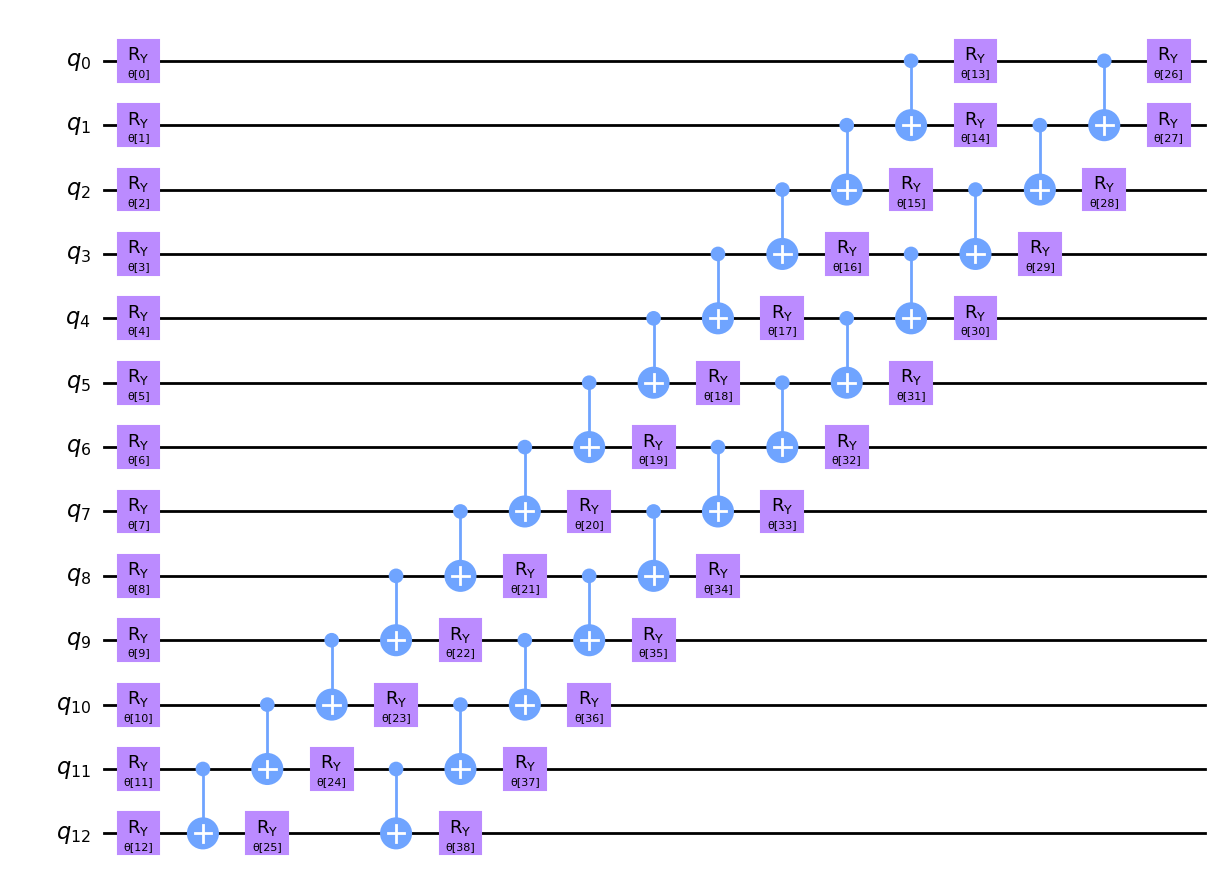

In [6]:
from qiskit.circuit.library import TwoLocal, PauliTwoDesign, RealAmplitudes

AnsatzChoice = RealAmplitudes
ansatz = AnsatzChoice(num_qubits=feature_map.num_qubits, reps=2)

ansatz.decompose().draw("mpl")

Finally, we have to define the optimizer to use and, a priori, we will choose between these three:

1. `COBYLA`: Best for small-scale, constraint-based problems where gradients are not available.
2. `ADAM`: Efficient for large-scale problems with its adaptive gradient mechanism, commonly used in deep learning.
3. `SPSA`: Suitable for high-dimensional problems, particularly in noisy environments, offering a gradient-free approach.

Unfortunately, the `ADAM` optimizer brings a lot of memory problmes and, with the `TwoLocal` ansatz cannot directly execute. This is probably due to the specific implementation developed by Qiskit. It is a pity, because, in our case, `ADAM` could have been very effective, given its efficiency in handling gradient information and faster convergence. Alternatively, we will choose `COBYLA` due to its suitability for small-scale problems as this is. 

Ultimately, however, the effectiveness of these optimizers can also depend on the specific configuration of the quantum machine learning model and the quantum hardware being used, so empirical testing and adjustment might be necessary to determine the best optimizer for the wine dataset in a practical scenario, as it happened with the feature map and the ansatz. A problem that all the optimizers could face is Barren Plateaus, which refers to a problem where the landscape of the optimization function becomes flat, making it extremely difficult to train the model.

In [7]:
from qiskit.algorithms.optimizers import COBYLA, SPSA

OptimizerChoice = COBYLA
optimizer = OptimizerChoice(maxiter=100)

/tmp/ipykernel_4130/2555952395.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA


Now, we are in conditions to build the VQC using the preferred options to be able to train it and see if our guesses were correct.

In [8]:
# 4. Build the variational quantum classifier using the feature map, ansatz, and optimizer

from qiskit_machine_learning.algorithms import VQC
from qiskit import Aer
from qiskit.primitives import Sampler

from IPython.display import clear_output

# Array with the objective function values for each iteration
objective_func_vals = []

plt.rcParams["figure.figsize"] = (12, 6)
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)
    clear_output(wait=True)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

vqc = VQC(feature_map=feature_map,
            sampler=Sampler(), 
            ansatz=ansatz,
            loss='cross_entropy',
            callback=callback_graph,
            optimizer=optimizer)

## 3. Run the VQC with the train data.  <a class="anchor" id="apartado3"></a>

And now, once the VQC is built, we proceed to execute the VQC and check the results.

In [ ]:
import timeit
start = timeit.timeit()
vqc.fit(train_data.data, train_data.labels)
end = timeit.timeit()
print(end - start)

The result are not displayed in the notebook due to its long compilation time. As we will see, almost every combination of elements (feature map, ansatz and optimizer) takes 1 hour to execute. Instead the code are snippets of the actual code executed on a HPC cluster. This is also a sign of the enourmous computational resources required nowadays to be able to perform even small trainings as we are doing with the wine dataset.

Once this appreciation has being made, we proceed to say that the results were pretty poor, yielding a 50.00% rate of accuracy on the clasiffication. This is slightly better than an random guess (which corresponds with a 33% accuracy in this case, because there are 3 classes), but not near the 90% of accuracy that we usually get in this type of datasets in classical ML.

## 4. Run the VQC with variations. <a class="anchor" id="apartado4"></a>

Due to the poor results yielded by our guess, we will test all the possible combinations to see which one performs best and to see how many time does each combination takes to execute.

In [ ]:
# Test the code with different map, ansatz, and optimizer
maps = [PauliFeatureMap, ZFeatureMap, ZZFeatureMap]
ansatzs = [TwoLocal, PauliTwoDesign, RealAmplitudes]
optimizers = [COBYLA, SPSA]

vqcs = {}

for map in maps:
    vqcs[map.__name__] = {}
    print(f"- Map: {map.__name__}")
    for ansatz in ansatzs:
        print(f"\t- Ansatz: {ansatz.__name__}")
        vqcs[map.__name__][ansatz.__name__] = {}
        for optimizer in optimizers:
            print(f"\t\t- Optimizer: {optimizer.__name__}")
            vqcs[map.__name__][ansatz.__name__][optimizer.__name__] = {}

            feature_map = map(feature_dimension=train_data.data.shape[1], reps=2)
            ansatz = ansatz(num_qubits=feature_map.num_qubits, reps=2)
            optimizer = optimizer(maxiter=100)

            objective_func_vals = []

            vqc = VQC(feature_map=feature_map,
                    sampler=Sampler(), 
                    ansatz=ansatz,
                    loss='cross_entropy',
                    callback=callback_graph,
                    optimizer=optimizer)
            vqc.fit(train_data.data, train_data.labels)

            plt.savefig(f"map_{map.__name__}_ansatz_{ansatz.__name__}_optimizer_{optimizer.__name__}.png")

            vqcs[map.__name__][ansatz.__name__][optimizer.__name__]['vqc'] = vqc
            vqcs[map.__name__][ansatz.__name__][optimizer.__name__]['score'] = vqc.score(test_data.data, test_data.labels)
            vqcs[map.__name__][ansatz.__name__][optimizer.__name__]['objective_func_vals'] = objective_func_vals
            print(f"\t\tMap: {map.__name__}, Ansatz: {ansatz.__name__}, Optimizer: {optimizer.__name__}")
            print(f"\t\tScore: {vqcs[map.__name__][ansatz.__name__][optimizer.__name__]['score']}")
            print("--------------------------------------------------------")

Just as before, due to long execution times, we will portrayed here the results obtained in the HPC cluster using the snippet showed above.

<center>

|   Feature map   |     Ansatz     | Optimizer | Accuracy | Time (s) |
|:---------------:|:--------------:|:---------:|:--------:|:--------:|
| PauliFeatureMap |    TwoLocal    |   COBYLA  |  27,78%  |   41,18  |
| PauliFeatureMap |    TwoLocal    |    SPSA   |  19,44%  |   41,31  |
| PauliFeatureMap | PauliTwoDesign |   COBYLA  |  38,89%  | 4.297,54 |
| PauliFeatureMap | PauliTwoDesign |    SPSA   |  22,22%  | 9.878,57 |
| PauliFeatureMap | RealAmplitudes |   COBYLA  |  38,89%  | 4.276,01 |
| PauliFeatureMap | RealAmplitudes |    SPSA   |  30,56%  | 9.878,77 |
|   ZFeatureMap   |    TwoLocal    |   COBYLA  |  33,33%  |   29,24  |
|   ZFeatureMap   |    TwoLocal    |    SPSA   |  38,89%  |   29,79  |
|   ZFeatureMap   | PauliTwoDesign |   COBYLA  |  61,11%  | 3.229,44 |
|   ZFeatureMap   | PauliTwoDesign |    SPSA   |  41,67%  | 7.463,24 |
|   ZFeatureMap   | RealAmplitudes |   COBYLA  |  88,89%  | 3.221,23 |
|   ZFeatureMap   | RealAmplitudes |    SPSA   |  69,44%  | 7.611,26 |
|   ZZFeatureMap  |    TwoLocal    |   COBYLA  |  25,00%  |   30,96  |
|   ZZFeatureMap  |    TwoLocal    |    SPSA   |  33,33%  |   30,61  |
|   ZZFeatureMap  | PauliTwoDesign |   COBYLA  |  33,33%  | 4.296,76 |
|   ZZFeatureMap  | PauliTwoDesign |    SPSA   |  27,78%  | 9.927,62 |
|   ZZFeatureMap  | RealAmplitudes |   COBYLA  |  50,00%  | 3.841,23 |
|   ZZFeatureMap  | RealAmplitudes |    SPSA   |  22,22%  | 9.048,76 |

</center>

And we see that the best accuracy, by far, is yielded by the `ZFeatureMap` map with the `RealAmplitudes` ansatz using `COBYLA` resulting in a 88,89% of accuracy. We were wrong guessing that the feature-feature interactions were important for the classifying of wine classes, but, instead, the simplicity of the `ZFeatureMap` map resulted in a much better classification.

If we focus on the general results, we can extract some conclusions from each part of the QNN. Below, we can see the accuracy of each type of each part in the charts. Let's analyze them.

- **Feature map.** First of all, it shows that the `ZFeatureMap` is consistenly better that the other two feature maps considered as we have seen in the best accuracy displayed in the table. Moreover, we can see that, in average, the `PauliFeatureMap` and the `ZZFeatureMap` result in similar accuracies. This could be explained by the complexity of those two maps in comparison with the `ZFeatureMap`.
- **Ansatz**. The most outstanding result is that the `TwoLocal` is the the worst ansatz possible from the three available, but, if look at the table, the surprise is even bigger due to the short time taken to execute. This is extremely rare and is almost like Qiskit rejects the training of this type of ansatz for unknown reasons. On the other hand, the `RealAmplitudes` ansatz responds notably better that the other two, but not excellent, reaching below 50% on average.
- **Optimizer**. Last but no least, we see that the `COBYLA` optimizer outperforms the SPSA optimizer.
  

<center>
<p float="left">
  <img src="images/accuracy-feature-map.png" width="500" />
  <img src="images/accuracy-ansatz.png" width="500" /> 
  <img src="images/accuracy-optimizer.png" width="500" />
</p>
</center>

To add some additional information about the ansatz and the optimizer, we see the charts below. There, we see that the mean relations are maintained throw the combination and, for example, the `RealAmplitudes` performance is not the best of the three just because takes part on the best accuracy, but because it consistently beats the rest of the ansatz. And the same happens with the `COBYLA` optimizer. 

<center>
<p float="left">
  <img src="images/optimizer-average.png" width="500" />
  <img src="images/ansatz-average.png" width="500" /> 
</p>
</center>

## 4. Conclusions

We explored the application of quantum machine learning (QML) to the wine dataset by sklearn, a standard classification task in classical machine learning. This involved understanding various aspects of quantum computing, particularly in the context of QML, such as feature maps, ansatzes, and optimizers.

#### Feature Maps and Ansatz Selection:
To determine the quantum part of the problem, this is define the employed circuit, we had to differentiate between two parts: the feature map and the ansatz.

- Feature Maps: We discussed the significance of choosing an appropriate quantum feature map to encode classical data into quantum states. For the wine dataset, the `ZZFeatureMap` was suggested as a potential choice due to its ability to capture feature-feature interactions, which could be pivotal in classifying different types of wine. Intead, a `ZFeatureMap` yielded better results than expected, which shows that the feature-feature interactions were too cumbersome for the classification at hand.
- Ansatzes: The choice of ansatz is critical in defining the quantum circuit for the task. The `RealAmplitudes` ansatz was deemed suitable for the wine dataset, given its focus on real-valued amplitudes and simplicity, aligning well with the nature of the dataset. This proved to be true and the `RealAmplitudes` ansatz yielded some pretty good results.

#### Optimizers:
This corresponds to the classical part of the problem, due to the fact that the optimizer for QML acts exactly the same as in classical ML: it focuses on minimizing a cost function. Obviously, in this case the cost function arises from the execution of a quantum circuit, but the optimization of the parameters remains classical.

- Choice of Optimizers: The effectiveness of `COBYLA` and `SPSA` as optimizers for this quantum task was evaluated. `COBYLA` was identified as a strong candidate due to its efficiency in handlingt small-scale problems as this is, even though our preferred candidate originally was `ADAM` which was discarded because of the troubleshooting its Qiskit implementation provided.

#### Challenges and Difficulties:
- Complexity: Quantum machine learning introduces complexities not present in classical machine learning, with intricacies of quantum state manipulation.
- Optimizer Selection: The choice of optimizer plays a crucial role in the model's performance, especially given the high-dimensional nature of quantum parameter spaces.
- Barren Plateaus: A significant challenge in QML is the occurrence of barren plateaus in the optimization landscape, which can severely hinder the training of quantum models. This issue is accentuated with deeper quantum circuits and more complex tasks.

The field of QML is rich with potential but comes with unique challenges. The careful selection of feature maps, ansatzes, and optimizers is crucial for successful implementation. The dynamic and rapidly evolving nature of quantum computing necessitates ongoing research and empirical testing to optimize these models effectively. In conclusion, while quantum machine learning offers new horizons in data analysis and pattern recognition, it requires a profound understanding of both quantum mechanics and machine learning principles. The interplay of quantum circuit design, optimization strategies, and problem-specific considerations forms the basis of successfully applying QML to practical problems.